# PML tuning notebook (2D Helmholtz)

This notebook helps you **construct and tune Perfectly Matched Layer (PML)** parameters for your 2D variable–coefficient Helmholtz solver.

It does three things:

1. **Build/visualize** the PML damping profiles \(\sigma_x,\sigma_y\) and the complex stretch factors \(s_x, s_y\).
2. **Run a simple benchmark** (homogeneous medium + localized source) to see whether the PML absorbs outgoing waves.
3. **Sweep parameters** (`npml`, `m`, target reflection `R`, and/or `sigma_scale`) and report a quantitative “reflection” metric.

> **Assumption:** you will add PML support to the operator assembly (or temporarily use the fallback assembly provided here).  
> If your `operators.assemble.assemble_helmholtz_matrix` doesn’t yet support PML, this notebook includes a drop-in `assemble_helmholtz_matrix_pml(...)` you can use for experiments.


In [1]:
from __future__ import annotations

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Project imports (should exist in your repo)
from core.config import HelmholtzConfig, PMLConfig
from core.resolution import grid_from_ppw
from core.grid import idx

# If you already have these utilities, use them. Otherwise, comment them out and use the fallbacks below.
from core.rhs import assemble_rhs
from core.medium import build_medium
from core.cases import make_default_cases

from operators.solve import solve_linear_system, compute_residual

print("Imports OK")

Imports OK


## 1) User parameters

- `omega`: angular frequency \(\omega\)
- `ppw_target`: points-per-wavelength target (for the *minimum* wave speed)
- PML controls:
  - `npml`: thickness in grid nodes
  - `m`: polynomial grading order (typical 2–4)
  - `R_target`: desired reflection coefficient at normal incidence (typical 1e-6 – 1e-10)
  - `sigma_scale`: multiplier to “over/under” damp relative to the nominal formula


In [12]:
# --- PDE / grid ---
omega = 8.0
ppw_target = 10.0

# Case selection:
# keep the string name here; later you should do:
#   cases = make_default_cases()
#   case_cfg = cases[case_name]
case_name = "homogeneous"

# Domain size (must match what your Grid2D / mesh() and case builders assume)
lx, ly = 1.0, 1.0

# Enforce at least 501x501 (grid_from_ppw uses this as a lower bound per dimension)
n_min = 501
make_odd = True  # handy for putting a source exactly at the center node

# Conservative lower bound on wave speed used for grid spacing (sets smallest wavelength)
# For homogeneous c=1, keep 1.0. If your medium can go lower, set that minimum here.
c_min_for_grid = 1.0

# --- PML ---
use_pml = True

# Thickness in nodes. For 501x501, 25 can work, but 30–40 is usually safer for Helmholtz.
npml = 30

# Polynomial grading order (2–4 typical)
m = 3

# Target reflection coefficient at normal incidence (heuristic used for sigma_max)
R_target = 1e-8

# Multiplier to tune damping up/down from the nominal formula
sigma_scale = 1.0

# Apply PML on all sides (or toggle sides below if False)
pml_on_all_sides = True
pml_left = pml_right = pml_bottom = pml_top = True


## 2) Helpers: build \(\sigma\) profiles and stretch factors

We use the standard frequency-domain stretch

\[
s_x(x) = 1 + i\,\frac{\sigma_x(x)}{\omega}, \quad
s_y(y) = 1 + i\,\frac{\sigma_y(y)}{\omega}.
\]

A common “nominal” choice for \(\sigma_{\max}\) in a layer of physical thickness \(L\) is

\[
\sigma_{\max} \approx \sigma_{\max}^{\text{nom}} =
-\frac{(m+1)\,c_{\text{ref}}\,\ln(R)}{2L},
\]

where \(c_{\text{ref}}\) is a representative wavespeed (often `min(c)` or a local reference).  
In practice you tune via `sigma_scale`.


In [13]:
def pml_sigma_1d(n: int, npml: int, sigma_max: float, m: int,
                 enable_left: bool = True, enable_right: bool = True) -> np.ndarray:
    """Return 1D sigma profile of length n with polynomial grading in npml nodes at each enabled side."""
    s = np.zeros(n, dtype=float)
    if npml <= 0:
        return s

    # left side
    if enable_left:
        for i in range(npml):
            d = (npml - i) / npml   # 1 at boundary -> 0 at interface
            s[i] = sigma_max * (d ** m)

    # right side
    if enable_right:
        for i in range(n - npml, n):
            d = (i - (n - npml - 1)) / npml  # 0 at interface -> 1 at boundary (shifted)
            # make it 1 at boundary, 0 at interface:
            d = min(max(d, 0.0), 1.0)
            s[i] = max(s[i], sigma_max * (d ** m))

    return s


def sigma_max_nominal(c_ref: float, omega: float, npml: int, h: float, m: int, R: float) -> float:
    """Nominal sigma_max from a widely-used heuristic formula."""
    L = npml * h
    if L <= 0:
        return 0.0
    return -0.5 * (m + 1) * c_ref * np.log(R) / L


def stretch_factors(sig: np.ndarray, omega: float) -> np.ndarray:
    """s = 1 + i sigma/omega"""
    return 1.0 + 1j * sig / float(omega)

In [17]:
# --- Grid construction ---
grid = grid_from_ppw(
    omega=omega,
    ppw=ppw_target,
    lx=lx,
    ly=ly,
    c_min=c_min_for_grid,
    n_min=n_min,
    make_odd=make_odd
)

cfg = HelmholtzConfig(
    omega=omega,
    grid=grid
)

# --- Medium ---
X, Y = cfg.grid.mesh()

cases = make_default_cases()

def resolve_case(cases, case_name: str):
    # dict-style: {name: CaseConfig}
    if hasattr(cases, "keys"):
        if case_name in cases:
            return cases[case_name]

        # common aliases -> try to map "homogeneous" to something that exists
        aliases = {
            "homogeneous": ["homogeneous", "homog", "uniform", "constant", "const", "c0"],
        }
        for alt in aliases.get(case_name, []):
            if alt in cases:
                print(f'Case "{case_name}" not found; using "{alt}" instead.')
                return cases[alt]

        # if still not found, show options
        raise KeyError(f'Case "{case_name}" not found. Available: {list(cases.keys())}')

    # list-style: [CaseConfig, ...]
    for cc in cases:
        if getattr(cc, "name", None) == case_name:
            return cc

    raise KeyError(f'Case "{case_name}" not found in list of cases.')

case_cfg = resolve_case(cases, case_name)


c = build_medium(cfg, case_cfg, X, Y)

# --- Reference scales for PML ---
c_ref = float(np.min(c))                 # conservative wavespeed
h = max(cfg.grid.hx, cfg.grid.hy)         # worst grid spacing

sigma_max = sigma_scale * sigma_max_nominal(
    c_ref=c_ref,
    omega=omega,
    npml=npml,
    h=h,
    m=m,
    R=R_target
)

# --- PML side activation ---
if pml_on_all_sides:
    pml_left = pml_right = pml_bottom = pml_top = True

# --- PML profiles and stretch factors ---
sig_x = pml_sigma_1d(
    n=cfg.grid.nx,
    npml=npml,
    sigma_max=sigma_max,
    m=m,
    enable_left=pml_left,
    enable_right=pml_right
)

sig_y = pml_sigma_1d(
    n=cfg.grid.ny,
    npml=npml,
    sigma_max=sigma_max,
    m=m,
    enable_left=pml_bottom,
    enable_right=pml_top
)

sx = stretch_factors(sig_x, omega)
sy = stretch_factors(sig_y, omega)

# --- Diagnostics ---
print(f"Grid: {cfg.grid.nx} x {cfg.grid.ny}, h ≈ {h:.3g}")
print(f"c_ref = {c_ref:.3g}")
print(f"sigma_max = {sigma_max:.3g}")
print(f"PML thickness = {npml} nodes ({npml*h:.3g} physical units)")


Case "homogeneous" not found; using "const" instead.
Grid: 501 x 501, h ≈ 0.002
c_ref = 1
sigma_max = 614
PML thickness = 30 nodes (0.06 physical units)


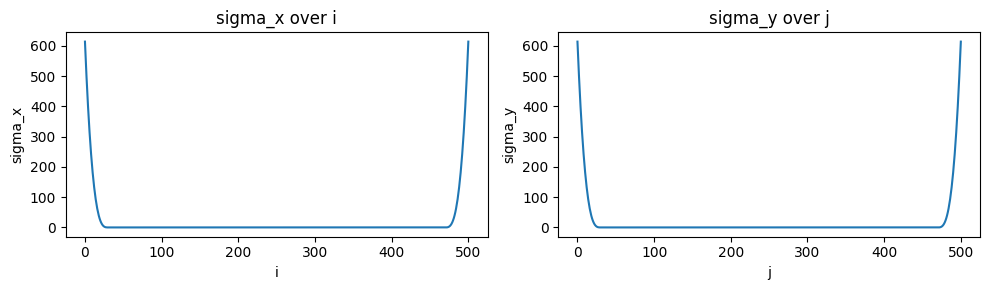

In [18]:
# Visualize sigma profiles
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(sig_x)
ax[0].set_title("sigma_x over i")
ax[0].set_xlabel("i")
ax[0].set_ylabel("sigma_x")

ax[1].plot(sig_y)
ax[1].set_title("sigma_y over j")
ax[1].set_xlabel("j")
ax[1].set_ylabel("sigma_y")

plt.tight_layout()
plt.show()

In [21]:
print("max sigma_x:", sig_x.max(), "max sigma_y:", sig_y.max())
print("max |s_x|:", np.abs(sx).max(), "max |s_y|:", np.abs(sy).max())
print("max Im(s_x):", np.imag(sx).max(), "max Im(s_y):", np.imag(sy).max())


max sigma_x: 614.0226914650789 max sigma_y: 614.0226914650789
max |s_x|: 76.75935057393042 max |s_y|: 76.75935057393042
max Im(s_x): 76.75283643313486 max Im(s_y): 76.75283643313486


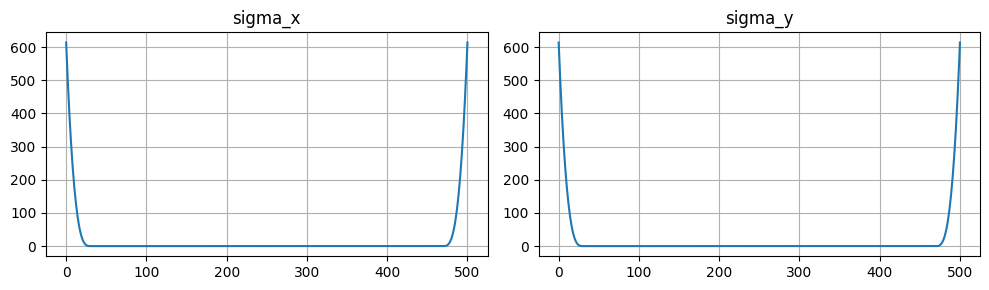

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.plot(sig_x); plt.title("sigma_x"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(sig_y); plt.title("sigma_y"); plt.grid(True)
plt.tight_layout(); plt.show()


In [26]:
def reflection_metrics(U: np.ndarray, npml: int, band: int = 5) -> dict:
    """
    Quick proxy metrics for PML performance.

    Parameters
    ----------
    U : ndarray (nx, ny)
        Solution field (complex or real)
    npml : int
        PML thickness in grid points
    band : int
        Width of the interface band (in grid points)

    Returns
    -------
    dict with:
        core_max   : max |U| well inside the domain
        iface_max  : max |U| in a thin band just inside the PML
        iface/core: reflection proxy (smaller is better)
    """
    nx, ny = U.shape

    # Interior (exclude PML + small buffer)
    core = U[npml + band : nx - npml - band,
             npml + band : ny - npml - band]

    # Bands just inside the PML interface
    left_band   = U[npml : npml + band, :]
    right_band  = U[nx - npml - band : nx - npml, :]
    bottom_band = U[:, npml : npml + band]
    top_band    = U[:, ny - npml - band : ny - npml]

    core_max = float(np.max(np.abs(core)))
    iface_max = float(np.max(np.abs(np.concatenate([
        left_band.ravel(),
        right_band.ravel(),
        bottom_band.ravel(),
        top_band.ravel(),
    ]))))

    ratio = iface_max / (core_max + 1e-15)

    return {
        "core_max": core_max,
        "iface_max": iface_max,
        "iface/core": ratio,
    }


In [30]:
try:
    f = assemble_rhs(cfg, kind="gaussian")
except Exception:
    # fallback: centered Gaussian
    X, Y = cfg.grid.mesh()
    x0 = 0.5 * (cfg.grid.xmin + cfg.grid.xmax)
    y0 = 0.5 * (cfg.grid.ymin + cfg.grid.ymax)
    sigma = 0.05

    g = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    f = g.reshape(-1)


AttributeError: 'Grid2D' object has no attribute 'xmin'

In [28]:
metrics = reflection_metrics(u, npml=npml, band=5)
metrics


NameError: name 'u' is not defined

## 3) PML-aware assembly (fallback)

If your repo has not yet been updated, this is a **local** sparse assembly that implements:

\[
-\frac{1}{s_x}\partial_x\left(\frac{1}{s_x}\partial_x u\right)
-\frac{1}{s_y}\partial_y\left(\frac{1}{s_y}\partial_y u\right)
- k^2 u = f.
\]

The discretization uses **half-step averaging** of \(b_x=1/s_x\) and \(b_y=1/s_y\).  
This is a reasonable first implementation for tuning (you can refine later).

> Note: You should *not* enforce Dirichlet on the outer boundary when using PML; the PML should handle absorption.  
> The fallback below keeps a minimal “do-nothing-ish” outer stencil by mirroring coefficients. For production, prefer a clean implementation inside your project assembly.


In [19]:
def assemble_helmholtz_matrix_pml(cfg: HelmholtzConfig, c: np.ndarray, sx: np.ndarray, sy: np.ndarray) -> sp.csr_matrix:
    nx, ny = cfg.grid.nx, cfg.grid.ny
    hx, hy = cfg.grid.hx, cfg.grid.hy
    N = nx * ny

    k2 = (cfg.omega / c) ** 2

    # b = 1/s
    bx = 1.0 / sx
    by = 1.0 / sy

    # half-step averages
    bx_ip = 0.5 * (bx[1:] + bx[:-1])  # length nx-1 corresponds to i+1/2
    by_jp = 0.5 * (by[1:] + by[:-1])  # length ny-1 corresponds to j+1/2

    inv_hx2 = 1.0 / (hx * hx)
    inv_hy2 = 1.0 / (hy * hy)

    rows, cols, data = [], [], []

    def add(p, q, v):
        rows.append(p); cols.append(q); data.append(v)

    for i in range(nx):
        for j in range(ny):
            p = idx(i, j, ny)

            # Neumann-like closure at outer boundary by clamping half-step indices
            # (lets PML do the absorption; avoids hard reflections from u=0)
            im = max(i - 1, 0)
            ip = min(i + 1, nx - 1)
            jm = max(j - 1, 0)
            jp = min(j + 1, ny - 1)

            # Half-step coefficients (clamped)
            bx_mh = bx_ip[im] if i > 0 else bx_ip[0]
            bx_ph = bx_ip[i] if i < nx - 1 else bx_ip[-1]
            by_mh = by_jp[jm] if j > 0 else by_jp[0]
            by_ph = by_jp[j] if j < ny - 1 else by_jp[-1]

            # Center multipliers
            bxi = bx[i]
            byj = by[j]

            # x-part: -bxi * ( bx_ph*(u_{i+1}-u_i) - bx_mh*(u_i-u_{i-1}) ) / hx^2
            cxm = -bxi * (-bx_mh) * inv_hx2   # multiplies u_{i-1}
            cxp = -bxi * ( bx_ph) * inv_hx2   # multiplies u_{i+1}
            cxc = -bxi * (-(bx_ph + bx_mh)) * inv_hx2  # multiplies u_i

            # y-part: -byj * ( by_ph*(u_{j+1}-u_j) - by_mh*(u_j-u_{j-1}) ) / hy^2
            cym = -byj * (-by_mh) * inv_hy2
            cyp = -byj * ( by_ph) * inv_hy2
            cyc = -byj * (-(by_ph + by_mh)) * inv_hy2

            diag = (cxc + cyc) - k2[i, j]
            add(p, p, diag.astype(complex))

            if i > 0:
                add(p, idx(i - 1, j, ny), cxm.astype(complex))
            if i < nx - 1:
                add(p, idx(i + 1, j, ny), cxp.astype(complex))
            if j > 0:
                add(p, idx(i, j - 1, ny), cym.astype(complex))
            if j < ny - 1:
                add(p, idx(i, j + 1, ny), cyp.astype(complex))

    return sp.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

## 4) Build a localized RHS and solve

If your project has `assemble_rhs`, use it. Otherwise, we’ll create a simple Gaussian source near the center.

We then compare:

- **Interior amplitude**: max |u| in a “core” region away from PML
- **PML reflection proxy**: max |u| in a thin band just inside the PML interface (lower is better)

These aren’t perfect, but they’re quick and work well for parameter tuning.


In [20]:
def gaussian_source(cfg: HelmholtzConfig, x0: float, y0: float, sigma: float = 0.05) -> np.ndarray:
    X, Y = cfg.grid.mesh()
    g = np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
    return g.reshape(-1)

# Build RHS
try:
    f = assemble_rhs(cfg, kind="gaussian")  # adjust to your rhs API if needed
except Exception:
    # fallback: centered Gaussian
    f = gaussian_source(cfg, x0=0.5*(cfg.grid.xmin+cfg.grid.xmax), y0=0.5*(cfg.grid.ymin+cfg.grid.ymax), sigma=0.05)

# Assemble matrix: prefer project operator if it supports PML, else use fallback
try:
    A = assemble_helmholtz_matrix(cfg, c)  # if your project has been updated
    used = "project assemble_helmholtz_matrix"
except Exception as e:
    A = assemble_helmholtz_matrix_pml(cfg, c, sx=sx, sy=sy)
    used = f"fallback assemble_helmholtz_matrix_pml (reason: {type(e).__name__})"

print("Using:", used)

# Solve
try:
    u = solve_linear_system(A, f)  # your project solver
except Exception:
    u = spla.spsolve(A, f)

u = np.asarray(u).reshape(-1)
print("||u||_2 =", np.linalg.norm(u))

AttributeError: 'Grid2D' object has no attribute 'xmin'

In [ ]:
# Visualize |u|
U = u.reshape(cfg.grid.nx, cfg.grid.ny)

plt.figure(figsize=(5,4))
plt.imshow(np.abs(U).T, origin="lower", aspect="auto")
plt.title("|u|")
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
def reflection_metrics(U: np.ndarray, npml: int, band: int = 3) -> dict:
    """Compute quick absorption/reflection proxies."""
    nx, ny = U.shape
    # core region excludes PML + small buffer
    core = U[npml+band:nx-npml-band, npml+band:ny-npml-band]
    # interface band just inside PML start
    left_band   = U[npml:npml+band, :]
    right_band  = U[nx-npml-band:nx-npml, :]
    bottom_band = U[:, npml:npml+band]
    top_band    = U[:, ny-npml-band:ny-npml]

    core_max = float(np.max(np.abs(core)))
    iface_max = float(np.max(np.abs(np.concatenate([
        left_band.ravel(), right_band.ravel(), bottom_band.ravel(), top_band.ravel()
    ]))))

    # smaller is better
    ratio = iface_max / (core_max + 1e-15)
    return {"core_max": core_max, "iface_max": iface_max, "iface/core": ratio}

metrics = reflection_metrics(U, npml=npml, band=5)
metrics

## 5) Parameter sweep

We sweep a small grid of parameters and report the reflection proxy `iface/core`.  
Lower is better (but if you overdamp too aggressively you can also distort the interior solution).

Tip: start by sweeping `sigma_scale` for a fixed `npml` and `m`, then adjust `npml`.


In [ ]:
def run_once(npml: int, m: int, R_target: float, sigma_scale: float) -> dict:
    # update cfg + recompute sigma profiles
    cfg2 = HelmholtzConfig(
        omega=omega,
        grid=grid,
        pml=PMLConfig(npml=npml, m=m, R_target=R_target, sigma_scale=sigma_scale)
    )
    X2, Y2 = cfg2.grid.mesh()
    c2 = build_medium(cfg2, case, X2, Y2)

    c_ref2 = float(np.min(c2))
    h2 = max(cfg2.grid.hx, cfg2.grid.hy)
    sigma_max2 = sigma_scale * sigma_max_nominal(c_ref2, omega, npml, h2, m, R_target)

    sig_x2 = pml_sigma_1d(cfg2.grid.nx, npml, sigma_max2, m, pml_left, pml_right)
    sig_y2 = pml_sigma_1d(cfg2.grid.ny, npml, sigma_max2, m, pml_bottom, pml_top)
    sx2 = stretch_factors(sig_x2, omega)
    sy2 = stretch_factors(sig_y2, omega)

    # RHS
    try:
        f2 = assemble_rhs(cfg2, kind="gaussian")
    except Exception:
        f2 = gaussian_source(cfg2, x0=0.5*(cfg2.grid.xmin+cfg2.grid.xmax), y0=0.5*(cfg2.grid.ymin+cfg2.grid.ymax), sigma=0.05)

    # A
    try:
        A2 = assemble_helmholtz_matrix(cfg2, c2)
    except Exception:
        A2 = assemble_helmholtz_matrix_pml(cfg2, c2, sx=sx2, sy=sy2)

    # solve
    try:
        u2 = solve_linear_system(A2, f2)
    except Exception:
        u2 = spla.spsolve(A2, f2)

    U2 = np.asarray(u2).reshape(cfg2.grid.nx, cfg2.grid.ny)
    met = reflection_metrics(U2, npml=npml, band=5)
    out = dict(npml=npml, m=m, R_target=R_target, sigma_scale=sigma_scale, **met)
    return out


# Sweep ranges
npml_list = [10, 15, 20, 25, 30]
m_list = [2, 3, 4]
sigma_scale_list = [0.5, 1.0, 2.0]

results = []
for npml_ in npml_list:
    for m_ in m_list:
        for ss_ in sigma_scale_list:
            results.append(run_once(npml_, m_, R_target, ss_))

# Pretty print best few
results_sorted = sorted(results, key=lambda d: d["iface/core"])
for r in results_sorted[:10]:
    print(r)

## 6) What “good” looks like

- `iface/core` should drop **orders of magnitude** compared to a no-PML (Dirichlet) run.
- Increasing `npml` usually helps more reliably than cranking `sigma_scale`.
- If `sigma_scale` is too high you may see:
  - solution distortion near the PML interface,
  - worse conditioning / slower iterative solves.
